In [1]:
import pint
si = pint.UnitRegistry()

In [2]:
from scipy.stats import lognorm
import numpy as np

In [3]:
from PyCloudParcel.parcel import parcel
from PyCloudParcel.phys import phys

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
si.setup_matplotlib()

In [118]:
rd = np.exp(np.linspace(
    np.log(20), # TODO: was 1nm in the paper...
    np.log(1000),
    20
)) * si.nanometre

In [119]:
ph = phys(si)

T0 = 280 * si.kelvin
p0 = 1000 * si.hectopascals
RH0 = .99

q0 = ph.eps/(p0 /RH0 /ph.pvs(T0) -1) 

In [120]:
rm = 0.08 * si.micrometre
sg = 1.45
N = 100 / si.centimetre**3 #TODO

rho = p0 / ph.R(q0) / T0
nd = lognorm.pdf(rd.magnitude, np.log(sg), 0, rm.magnitude)
nd *= N / rho / np.sum(nd)  

In [135]:

w = 0.5 * si.metre / si.second
integ, sys = parcel(
    si = si,
    t = 1000 * si.seconds,
    T0 = T0,
    q0 = q0,
    p0 = p0,
    w = lambda t: np.sin(t/100/si.seconds) * w,
    nd = nd, 
    rd = rd, 
    kp = 0.9, #TODO: check
    dt_max = .5 * si.second,
    thermo = ('S','p'),
    micro = ('r', 'T')
)

C:\Users\Michael\Anaconda3\lib\site-packages\pint\quantity.py:888: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
C:\Users\Michael\Anaconda3\lib\site-packages\pint\quantity.py:686: RuntimeWarning: invalid value encountered in double_scalars
  magnitude = op(self._magnitude, other._magnitude)


C:\Users\Michael\Anaconda3\lib\site-packages\pint\quantity.py:1488: RuntimeWarning: invalid value encountered in sqrt
  return ufunc(*mobjs)


AssertionError: Required step size is less than spacing between numbers.

In [130]:
ix = sys.ix
fn = sys.fn
ph = sys.ph

In [131]:
p = integ.y[ix.p] * ix.p_unit
r = fn.r(integ.y[ix.x] * ix.x_unit)
t = integ.t * ix.t_unit
S = integ.y[ix.S] * ix.S_unit
Td = integ.y[ix.Td] * ix.T_unit

q = ph.q(sys.q1, nd, r)
T = ph.T(S,p,q)

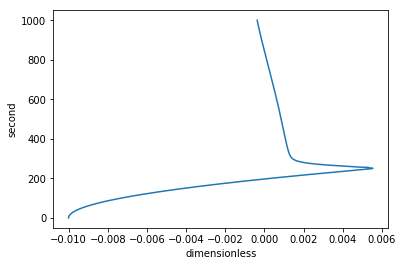

In [132]:
plt.plot(S,t)

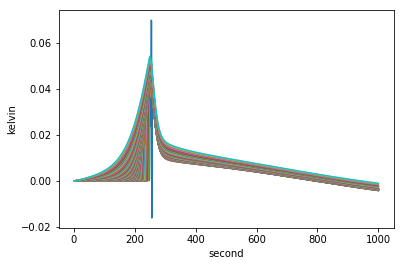

In [133]:
for i in range(len(Td)):
    plt.plot(t,Td[i]-T)

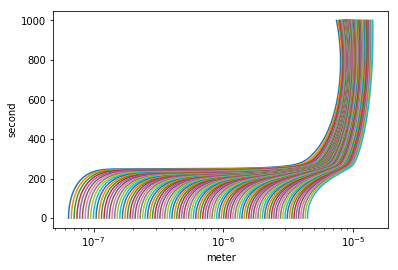

In [134]:
for i in range(len(Td)):
    plt.plot(r[i], t)
    plt.xscale('log')